In [1]:
!pip install nnfs

In [2]:
import numpy as np
import nnfs
import matplotlib.pyplot as plt
from tqdm import tqdm

nnfs.init()

## Dense Layers : fully connected layers

Weights defined as transpose for efficiency

## Activation functions:
            - ReLU
            - Softmax

## Loss function


In [3]:
class Layer_Dense:
    def __init__(self, num_inputs, num_neurons):
        # initialize weights and biases
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons) # <<- already transposed
        self.biases = np.zeros((1,num_neurons))

    def forward(self, inputs):
        # calculate output values from inputs,weights adn biases
        self.output = np.matmul(inputs, self.weights) + self.biases

In [4]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

In [5]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_vals = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
        self.output = prob

In [6]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        mean_loss = np.mean(sample_losses)
        return mean_loss

class Lss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        num_samples = len(y_pred)
        # Clip to avoid log(0) 
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Depending on y shape we distinguish between y elements being class index or a one-hot array
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[ range(num_samples), y_true ]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum( y_pred_clipped * y_true, axis=1 ) # because truth is one hot
        # 
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    

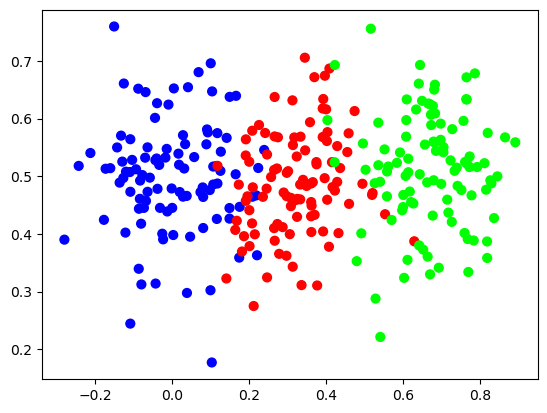

In [7]:
# Example run
from nnfs.datasets import vertical_data

np.random.seed(123)
X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

dense1 = Layer_Dense(2,3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3,3)
activation2 = Activation_Softmax()
loss_function = Lss_CategoricalCrossEntropy()


## Optimization Method 1 (not really a method): Randomly initialize weights until an optimal is found

In [8]:
min_loss = 99999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

In [10]:
for iteration in tqdm(range(100000)):
    # Generate new weights
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1,3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1,3)

    # Calculate forward pass on NN
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # loss and accuracy of the pass:
    loss = loss_function.calculate(activation2.output, y)
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    # see if we found a new min loss:
    if loss < min_loss:
        print("New min found:", iteration, "Loss:", loss, "Accuracy:", accuracy)
        min_loss = loss
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()



  3%|██                                                                        | 2825/100000 [00:00<00:10, 9627.06it/s]

New min found: 872 Loss: 1.0966641 Accuracy: 0.3333333333333333
New min found: 2242 Loss: 1.0959613 Accuracy: 0.3466666666666667


 13%|█████████▋                                                              | 13439/100000 [00:01<00:07, 11045.99it/s]

New min found: 11659 Loss: 1.0956659 Accuracy: 0.3333333333333333


 24%|█████████████████▌                                                      | 24324/100000 [00:02<00:06, 11867.64it/s]

New min found: 22748 Loss: 1.0956057 Accuracy: 0.3333333333333333


 81%|██████████████████████████████████████████████████████████▍             | 81190/100000 [00:07<00:01, 12059.16it/s]

New min found: 79030 Loss: 1.0955932 Accuracy: 0.3333333333333333


 87%|██████████████████████████████████████████████████████████████▉         | 87334/100000 [00:07<00:01, 11974.55it/s]

New min found: 85465 Loss: 1.0950214 Accuracy: 0.3333333333333333


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 11536.13it/s]


#### Above method doesn't work! It is a programmed trial-and-error method which is too slow to converge, even for a computer!

## Optimization Method 2 : add a small change to existing weights to see if there is an improvement at each iteration

In [11]:
min_loss = 99999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

In [13]:
for iteration in tqdm(range(100000)):
    # Generate new weights
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1,3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1,3)

    # Calculate forward pass on NN
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # loss and accuracy of the pass:
    loss = loss_function.calculate(activation2.output, y)
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    # see if we found a new min loss:
    if loss < min_loss:
        print("New min found:", iteration, "Loss:", loss, "Accuracy:", accuracy)
        min_loss = loss
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
    else:
        # revert the changes back
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()



  2%|█▌                                                                       | 2076/100000 [00:00<00:09, 10389.42it/s]

New min found: 1 Loss: 0.92368287 Accuracy: 0.5766666666666667
New min found: 3 Loss: 0.91549236 Accuracy: 0.6566666666666666
New min found: 6 Loss: 0.8852546 Accuracy: 0.65
New min found: 7 Loss: 0.8341767 Accuracy: 0.6566666666666666
New min found: 10 Loss: 0.81960875 Accuracy: 0.65
New min found: 11 Loss: 0.7910664 Accuracy: 0.5966666666666667
New min found: 17 Loss: 0.7493208 Accuracy: 0.6333333333333333
New min found: 20 Loss: 0.73496926 Accuracy: 0.65
New min found: 25 Loss: 0.7346166 Accuracy: 0.61
New min found: 28 Loss: 0.68563366 Accuracy: 0.6166666666666667
New min found: 29 Loss: 0.652742 Accuracy: 0.6633333333333333
New min found: 31 Loss: 0.63225293 Accuracy: 0.6766666666666666
New min found: 34 Loss: 0.5872525 Accuracy: 0.7233333333333334
New min found: 38 Loss: 0.57742995 Accuracy: 0.73
New min found: 39 Loss: 0.561897 Accuracy: 0.75
New min found: 40 Loss: 0.55016834 Accuracy: 0.7533333333333333
New min found: 41 Loss: 0.5388643 Accuracy: 0.76
New min found: 42 Loss: 0

  3%|██▎                                                                      | 3140/100000 [00:00<00:09, 10496.58it/s]

New min found: 2129 Loss: 0.1717202 Accuracy: 0.9266666666666666
New min found: 2172 Loss: 0.17165247 Accuracy: 0.9233333333333333
New min found: 2259 Loss: 0.17158972 Accuracy: 0.9266666666666666


  7%|████▊                                                                    | 6532/100000 [00:00<00:08, 11191.25it/s]

New min found: 4912 Loss: 0.17158699 Accuracy: 0.9266666666666666
New min found: 6943 Loss: 0.17155056 Accuracy: 0.9266666666666666
New min found: 7043 Loss: 0.17155045 Accuracy: 0.9266666666666666


 10%|███████▏                                                                 | 9800/100000 [00:00<00:08, 10504.48it/s]

New min found: 7860 Loss: 0.17152926 Accuracy: 0.9266666666666666


 13%|█████████▍                                                              | 13165/100000 [00:01<00:07, 10928.94it/s]

New min found: 11742 Loss: 0.17152883 Accuracy: 0.9266666666666666


 22%|███████████████▊                                                        | 22048/100000 [00:02<00:06, 11288.77it/s]

New min found: 20557 Loss: 0.17152731 Accuracy: 0.9266666666666666


 29%|████████████████████▌                                                   | 28563/100000 [00:02<00:06, 10310.62it/s]

New min found: 26707 Loss: 0.17151715 Accuracy: 0.9266666666666666
New min found: 26906 Loss: 0.17151025 Accuracy: 0.9233333333333333


 33%|███████████████████████▊                                                | 33058/100000 [00:03<00:06, 11015.15it/s]

New min found: 30888 Loss: 0.17149201 Accuracy: 0.9233333333333333


 45%|████████████████████████████████▌                                       | 45254/100000 [00:04<00:04, 11124.04it/s]

New min found: 43459 Loss: 0.17149171 Accuracy: 0.9266666666666666


 63%|█████████████████████████████████████████████▏                          | 62714/100000 [00:05<00:03, 10256.58it/s]

New min found: 61030 Loss: 0.17148946 Accuracy: 0.9233333333333333
New min found: 62643 Loss: 0.17147636 Accuracy: 0.9233333333333333


 67%|████████████████████████████████████████████████▏                       | 66978/100000 [00:06<00:03, 10341.91it/s]

New min found: 65321 Loss: 0.17147604 Accuracy: 0.9266666666666666


 73%|████████████████████████████████████████████████████▎                   | 72660/100000 [00:06<00:02, 10753.85it/s]

New min found: 70949 Loss: 0.17146286 Accuracy: 0.9266666666666666


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10620.09it/s]


### Above method works for this vertically divisable dataset! Next we try it on a harder dataset.

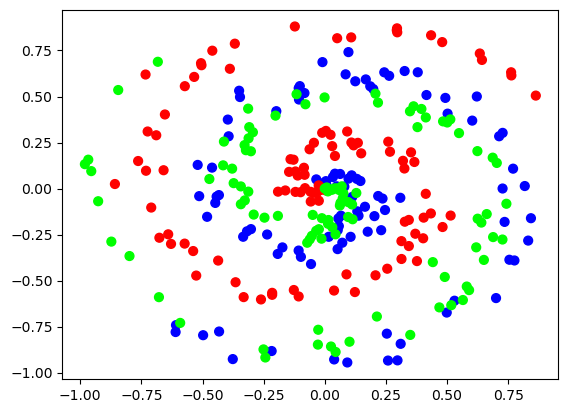

In [15]:
# Example run
from nnfs.datasets import spiral_data

np.random.seed(123)
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

dense1 = Layer_Dense(2,3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3,3)
activation2 = Activation_Softmax()
loss_function = Lss_CategoricalCrossEntropy()


In [16]:
min_loss = 99999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

In [18]:
for iteration in tqdm(range(100000)):
    # Generate new weights
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1,3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1,3)

    # Calculate forward pass on NN
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # loss and accuracy of the pass:
    loss = loss_function.calculate(activation2.output, y)
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    # see if we found a new min loss:
    if loss < min_loss:
        print("New min found:", iteration, "Loss:", loss, "Accuracy:", accuracy)
        min_loss = loss
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
    else:
        # revert the changes back
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()

print("At:", iteration, "Loss:", loss, "Accuracy:", accuracy)

  2%|█▌                                                                       | 2210/100000 [00:00<00:09, 10667.00it/s]

New min found: 259 Loss: 1.0168437 Accuracy: 0.43666666666666665
New min found: 617 Loss: 1.016732 Accuracy: 0.45
New min found: 1086 Loss: 1.0161226 Accuracy: 0.42
New min found: 1483 Loss: 1.01519 Accuracy: 0.43


  6%|████▏                                                                    | 5694/100000 [00:00<00:08, 10992.29it/s]

New min found: 3960 Loss: 1.0143605 Accuracy: 0.43333333333333335


  9%|██████▋                                                                  | 9157/100000 [00:00<00:08, 10947.62it/s]

New min found: 7966 Loss: 1.0141941 Accuracy: 0.45
New min found: 8921 Loss: 1.0141647 Accuracy: 0.4533333333333333
New min found: 10040 Loss: 1.0140017 Accuracy: 0.41


 12%|████████▉                                                               | 12460/100000 [00:01<00:08, 10638.74it/s]

New min found: 10543 Loss: 1.0133955 Accuracy: 0.45
New min found: 11217 Loss: 1.0133239 Accuracy: 0.43
New min found: 12286 Loss: 1.0132343 Accuracy: 0.45


 17%|████████████▏                                                           | 16990/100000 [00:01<00:07, 10667.41it/s]

New min found: 15661 Loss: 1.0132322 Accuracy: 0.43
New min found: 16107 Loss: 1.0126989 Accuracy: 0.43666666666666665


 21%|██████████████▉                                                         | 20691/100000 [00:01<00:06, 11756.06it/s]

New min found: 18500 Loss: 1.0126694 Accuracy: 0.44333333333333336
New min found: 18989 Loss: 1.0125015 Accuracy: 0.4266666666666667
New min found: 20528 Loss: 1.0116957 Accuracy: 0.42
New min found: 20752 Loss: 1.0109392 Accuracy: 0.43


 23%|████████████████▌                                                       | 23064/100000 [00:02<00:06, 11757.87it/s]

New min found: 21269 Loss: 1.010809 Accuracy: 0.43666666666666665
New min found: 21827 Loss: 1.0102029 Accuracy: 0.41
New min found: 22704 Loss: 1.0096929 Accuracy: 0.4266666666666667


 25%|██████████████████▎                                                     | 25473/100000 [00:02<00:06, 11493.49it/s]

New min found: 23826 Loss: 1.0096319 Accuracy: 0.43


 28%|███████████████████▉                                                    | 27767/100000 [00:02<00:06, 11071.05it/s]

New min found: 26049 Loss: 1.0094744 Accuracy: 0.41
New min found: 26982 Loss: 1.0089864 Accuracy: 0.44666666666666666


 36%|█████████████████████████▋                                              | 35699/100000 [00:03<00:05, 11276.89it/s]

New min found: 34075 Loss: 1.008306 Accuracy: 0.4266666666666667
New min found: 36382 Loss: 1.0077004 Accuracy: 0.43


 41%|█████████████████████████████▋                                          | 41272/100000 [00:03<00:05, 10649.27it/s]

New min found: 39258 Loss: 1.0073491 Accuracy: 0.4633333333333333


 63%|█████████████████████████████████████████████▋                           | 62616/100000 [00:05<00:03, 9981.61it/s]

New min found: 61333 Loss: 1.0072578 Accuracy: 0.43


 70%|██████████████████████████████████████████████████▌                     | 70305/100000 [00:06<00:02, 10822.48it/s]

New min found: 68767 Loss: 1.0072298 Accuracy: 0.4166666666666667


 73%|████████████████████████████████████████████████████▎                   | 72613/100000 [00:06<00:02, 11120.43it/s]

New min found: 71363 Loss: 1.0069562 Accuracy: 0.4533333333333333


 85%|█████████████████████████████████████████████████████████████▏          | 84944/100000 [00:07<00:01, 10927.08it/s]

New min found: 83338 Loss: 1.0068488 Accuracy: 0.41333333333333333
New min found: 85201 Loss: 1.0065409 Accuracy: 0.43333333333333335


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10937.35it/s]

At: 99999 Loss: 1.0285934 Accuracy: 0.4633333333333333


In [19]:
print("At:", iteration, "Loss:", loss, "Accuracy:", accuracy)

At: 99999 Loss: 1.0285934 Accuracy: 0.4633333333333333


#### On the spiral dataset this method is not fast enough to converge at a reasonable time. There are better ways to optimize a NN!